## Initial Setup

### Import necessary libraries

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import py7zr
import os
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from rpca import RPCA

ModuleNotFoundError: No module named 'sklearn'

### Decompress the .mat file if it is compressed

Following patient data and its quality:
- `S1.mat` $\rightarrow$ good patient data
- `S3.mat` $\rightarrow$ good patient data
- `S31.mat` $\rightarrow$ good patient data
- `S32.mat` $\rightarrow$ good patient data
- `S19.mat` $\rightarrow$ medium patient data
- `S29.mat` $\rightarrow$ bad patient data

In [10]:
subject = 1

# Path to the compressed file
compressed_file = f'./data/S{subject}.mat.7z'
mat_file = f'./data/S{subject}.mat'

# Check if the .mat file already exists
if os.path.exists(mat_file):
    print(f"Using existing file {mat_file}")
# Check if the compressed file exists
elif os.path.exists(compressed_file):
    # Extract the file
    with py7zr.SevenZipFile(compressed_file, mode='r') as z:
        z.extractall()
    print(f"Successfully extracted {compressed_file}")
else:
    print(f"File {compressed_file} not found")

Using existing file S1.mat


### Load the .mat file

In [11]:
# S1.mat # good patient data
# S3.mat # good patient data
# S19.mat # medium patient data
# S29.mat # bad patient data
# S31.mat # good patient data
# S32.mat # good patient data

eeg_data = sio.loadmat(mat_file)['data']
print(eeg_data.shape)

(64, 1500, 40, 6)


### Define useful global variables

In [12]:
frequency_to_index = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

samples = 250 # 250 samples analyzed at once
spacing = 4  # time between samples in ms
fs = 250  # 250 Hz sampling rate


time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000
default_freq_xlim = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

# Define all available channels with their corresponding indices
relevant_channels = {
    ### Secondary electrodes
    "FCz":18,
    "C5": 24,
    "C3": 25,
    "C1": 26,
    "C2": 28,
    "C4": 29,
    "C6": 30,
    "CPz": 37,
    "P7": 43,
    "P5": 44,
    "P3": 45,
    "P1": 46,
    "P2": 48,
    "P4": 49,
    "P6": 50,
    "P8": 51,

    ### Best electrodes
    ## Frontal
    "Cz": 27,
    
    ## Parietal
    "Pz": 47,
    
    ## Parieto-occipital
    "PO7": 52,
    "PO5": 53,
    "PO3": 54,
    
    "POz": 55,

    "PO4": 56,
    "PO6": 57,
    "PO8": 58,

    ## Occipital
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# Electrode sets with number of electrodes as key and channel name/index dict as value
channels_sets = {
    4:  {ch: relevant_channels[ch] for ch in ["POz", "O1", "Oz", "O2"]},
    8:  {ch: relevant_channels[ch] for ch in ["PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    9:  {ch: relevant_channels[ch] for ch in ["Pz", "PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    12: {ch: relevant_channels[ch] for ch in ["Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    14: {ch: relevant_channels[ch] for ch in ["P3", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    16: {ch: relevant_channels[ch] for ch in ["P3", "P1", "P2", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    18: {ch: relevant_channels[ch] for ch in ["P5", "P3", "P1", "P2", "P4", "P6", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    20: {ch: relevant_channels[ch] for ch in ["P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    22: {ch: relevant_channels[ch] for ch in ["FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    24: {ch: relevant_channels[ch] for ch in ["C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    26: {ch: relevant_channels[ch] for ch in ["C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    28: {ch: relevant_channels[ch] for ch in ["C5", "C6", "C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
}

selected_channels = channels_sets[16]

most_relevant_channels = {
    # "Pz": 47,
    # "POz": 55,
    # For most individuals
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# variables used for BCI experiments
evoked_frequencies = [8, 10, 12, 15] # frequencies to be used for the BCI experiment (in Hz)
default_evoked_frequency = 8
number_of_windows = 5 # number of windows to split into the useful trial interval (1 second segments along 5 seconds per trial)
number_of_trials = eeg_data.shape[3] # number of trials to use for the BCI experiment
bci_start_sample = 125 # the first 0.5 seconds are discarded
bci_end_sample = 1375 # the last 0.5 seconds are discarded

### Define useful functions

#### Pre-processing

In [13]:
## CAR
def apply_car_filter(eeg_data):
    """
    Apply Common Average Reference (CAR) filtering to EEG data.
    
    CAR subtracts the average of all electrodes from each individual electrode:
    V_i^CAR = V_i^EL - (1/n) * sum(V_j^EL) for all j electrodes
    
    Parameters:
    -----------
    eeg_data : numpy.ndarray
        Input EEG data with shape (channels, samples, frequencies, trials) or (channels, samples) or (trials, channels, samples)
        
    Returns:
    --------
    car_filtered : numpy.ndarray
        CAR-filtered EEG data with the same shape as the input
    """
    
    # Make a copy to avoid modifying the original data
    car_filtered = eeg_data.copy()
    
    # Determine if we have multiple multiple dimensions
    if len(eeg_data.shape) == 4:  # (channels, samples, frequencies, trials)
        n_of_trials = eeg_data.shape[3]
        n_of_frequencies = eeg_data.shape[2]
        # Calculate mean across channels for each trial
        for trial in range(n_of_trials):
            for freq in range(n_of_frequencies):
                channel_mean = np.mean(eeg_data[:, :, freq, trial], axis=0)
                car_filtered[:, :, freq, trial] = eeg_data[:, :, freq, trial] - channel_mean

    elif len(eeg_data.shape) == 3:  # (trials, channels, samples)
        # Calculate mean across channels for each trial
        channel_mean = np.mean(eeg_data, axis=1, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean

    else:  # (channels, samples)
        # Calculate mean across channels
        channel_mean = np.mean(eeg_data, axis=0, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean
    
    return car_filtered

## RPCA
def apply_rpca_filter(eeg_data, lambda_value, mu_value, selected_channels, start_sample, end_sample, evoked_frequencies):
    """
    Apply Robust Principal Component Analysis (RPCA) filtering to EEG data.
    
    RPCA decomposes the data matrix into two components:
    L: Low-rank component (representing the common background signal/neural activity)
    S: Sparse component (representing artifacts, outliers, and noise)

    The function processes the data in windows and returns both the low-rank (L) and 
    sparse (S) components separately.

    Args:
        eeg_data: numpy.ndarray
            Input EEG data with shape (channels, samples, frequencies, trials) or 
            (channels, samples) or (trials, channels, samples)
        lambda_value: float
            Regularization parameter for RPCA that controls the sparsity of S
        mu_value: float
            Step size parameter for the optimization algorithm in RPCA
        selected_channels: dict
            Dictionary mapping channel names to their indexes
        start_sample: int
            Starting sample index for processing
        end_sample: int
            Ending sample index for processing
        evoked_frequencies: list
            List of frequencies to be processed

    Returns:
        tuple of numpy.ndarray:
            L_pre_processed_eeg_data: Low-rank component with the same shape as the input
            S_pre_processed_eeg_data: Sparse component with the same shape as the input
    """
    # Get the indexes of selected channels
    selected_channels_indexes = list(selected_channels.values())
    
    # Initialize output array with same shape as input
    L_pre_processed_eeg_data = eeg_data.copy()
    S_pre_processed_eeg_data = eeg_data.copy()
    # Get the number of trials and frequencies
    n_trials = eeg_data.shape[3]
    
    # Process each trial and frequency separately
    for trial_idx in range(n_trials):
        for freq in evoked_frequencies:
            # Split the selected portion of EEG data into windows for processing
            windowed_eeg_data = np.split(
                eeg_data[selected_channels_indexes, start_sample:end_sample, frequency_to_index[freq], trial_idx],
                indices_or_sections=number_of_windows,
                axis=1
            )
            
            # Calculate the width (in samples) of each window for indexing
            window_width = windowed_eeg_data[0].shape[1]
            
            # Process each window separately
            for window_index, window in enumerate(windowed_eeg_data):
                # Initialize L and S components for current window
                L = np.zeros_like(window)
                S = np.zeros_like(window)
                
                # Apply RPCA decomposition to the current window
                # tolerance: convergence criterion
                # max_iteration: maximum number of iterations for the algorithm
                L_temp, S_temp = RPCA(window, lambda_value, mu_value, tolerance=10e-4, max_iteration=1000)
                
                # Store the decomposition results
                L += L_temp
                S += S_temp

                # Calculate the current window's position in the original data
                window_start = start_sample + window_index * window_width
                window_end = start_sample + (window_index + 1) * window_width
                
                # Update the output with filtered data
                L_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = L
                S_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = S

    return L_pre_processed_eeg_data, S_pre_processed_eeg_data



#### Feature Extraction

In [14]:
## Feature extraction
def get_label_vector(evoked_frequencies):
    Y = np.zeros(number_of_windows * number_of_trials * len(evoked_frequencies), int)

    for i, frequency in enumerate(evoked_frequencies):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                Y[i * number_of_trials * number_of_windows + j * number_of_windows + k] += i

    return Y

def get_label_matrix(evoked_frequencies):
    Y = np.ones((number_of_windows * number_of_trials * len(evoked_frequencies), len(evoked_frequencies)), int)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if int(i / (number_of_windows * number_of_trials)) != j:
                Y[i, j] *= -1

    return Y

def get_feature_matrix_from_eeg_time_domain(pre_processed_eeg_data, evoked_frequencies, selected_channels, start_sample, end_sample, select_first_harmonic=False):
    # Start dividing pre processed EEG Data into windows
    selected_channels_indexes = list(selected_channels.values())
    windowed_eeg_data = np.split(
        pre_processed_eeg_data[selected_channels_indexes, start_sample:end_sample, :, :],
        indices_or_sections=number_of_windows,
        axis=1
    )

    print('Windowed data:', np.array(windowed_eeg_data).shape)

    # Building X matrix
    number_of_frequencies = len(evoked_frequencies) * (2 if select_first_harmonic else 1)

    # Prepare X for vstack
    X = np.array([np.zeros(len(selected_channels) * number_of_frequencies)])

    frequency_values_to_select = evoked_frequencies
    if select_first_harmonic: # append the first harmonic if needed
        frequency_values_to_select = np.hstack(
            (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
        )

    # each column is a channel for a frequency and each row is a trial for a window
    # k is the window, j is the trial, i is the frequency, l is the channel
    frequencies_indexes = [frequency_to_index[freq] for freq in evoked_frequencies]
    for i, frequency_index in enumerate(frequencies_indexes):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                temp = np.array([])
                for l in range(len(selected_channels)):
                    channel_data = windowed_eeg_data[k][l, :, frequency_index, j]
                    channel_fft = np.abs(fft(channel_data))
                    temp = np.hstack((temp, channel_fft[frequency_values_to_select]))
                X = np.vstack((X, temp))

    # Drop the first line
    X = X[1:, :]

    print('Feature Matrix:', X.shape)

    return X

def get_knowledge_matrix_from_eeg_time_domain(eeg_data, pre_processed_eeg_data, evoked_frequencies, selected_channels, most_relevant_channels, start_sample, end_sample, select_first_harmonic=False):

    # Substitue the pre_processed_eeg_data on the most relevant channels
    # CAR only on the most relevant channels
    knowledge_domain_pre_processed_eeg_data = pre_processed_eeg_data.copy()
    car_filtered_eeg_data = apply_car_filter(eeg_data)
    for channel in most_relevant_channels:
        knowledge_domain_pre_processed_eeg_data[selected_channels[channel], :, :, :] = car_filtered_eeg_data[selected_channels[channel], :, :, :]

    # Start dividing pre processed EEG Data into windows
    selected_channels_indexes = list(selected_channels.values())
    windowed_eeg_data = np.split(
        knowledge_domain_pre_processed_eeg_data[selected_channels_indexes, start_sample:end_sample, :, :],
        indices_or_sections=number_of_windows,
        axis=1
    )

    print('Windowed data:', np.array(windowed_eeg_data).shape)

    # Building X matrix
    number_of_frequencies = len(evoked_frequencies) * (2 if select_first_harmonic else 1)

    # Prepare X for vstack
    X = np.array([np.zeros(len(selected_channels) * number_of_frequencies)])

    frequency_values_to_select = evoked_frequencies
    if select_first_harmonic: # append the first harmonic if needed
        frequency_values_to_select = np.hstack(
            (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
        )

    # each column is a channel for a frequency and each row is a trial for a window
    # k is the window, j is the trial, i is the frequency, l is the channel
    frequencies_indexes = [frequency_to_index[freq] for freq in evoked_frequencies]
    for i, frequency_index in enumerate(frequencies_indexes):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                temp = np.array([])
                for l in range(len(selected_channels)):
                    channel_data = windowed_eeg_data[k][l, :, frequency_index, j]
                    channel_fft = np.abs(fft(channel_data))
                    temp = np.hstack((temp, channel_fft[frequency_values_to_select]))
                X = np.vstack((X, temp))

    # Drop the first line
    X = X[1:, :]

    print('Feature Matrix:', X.shape)

    return X


#### Models

In [15]:
class LeastSquares:
    def __init__(self):
        self.W = None

    def fit(self, X, Y):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add bias
        
        self.W = np.matmul(np.linalg.pinv(X_plus_bias), Y)

    def predict(self, X):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # add bias

        predictions = np.matmul(X_plus_bias, self.W)
        
        return np.argmax(predictions, axis=1)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

#### Utils

In [16]:
## Data Extraction
def get_electrodes_data(eeg_data, trial, frequency, selected_channels, start_sample, end_sample):
    """
    Extract electrodes data for selected channels within a defined sample interval.
    
    Args:
        eeg_data: The EEG data matrix
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        selected_channels: Dictionary mapping channel names to indices
        start_sample: Starting sample index
        end_sample: Ending sample index
        
    Returns:
        Numpy array containing electrodes data for selected channels
    """
    frequency_index = frequency_to_index[frequency]
    electrodes_data = eeg_data[:, :, frequency_index, trial - 1]
    return electrodes_data[list(selected_channels.values()), start_sample:end_sample]

## Plotting
def plot_time_frequency(data_matrix, title_prefix, channels, 
                        time_range=time_range, freq_range=freq_range, frequency=None, 
                        figsize=(15, 10), freq_xlim=default_freq_xlim, show_grid=True):
    """
    Plot electrode data in both time and frequency domains.
    
    Args:
        data_matrix: Matrix containing electrode data with shape (electrodes, samples)
        title_prefix: Prefix string to add to plot titles
        channels: Dictionary mapping channel names to indices
        time_range: Array for time domain x-axis (default: global variable time_range)
        freq_range: Array for frequency domain x-axis (default: global variable freq_range)
        samples: Number of samples for FFT calculation (default: data_matrix.shape[1])
        frequency: Frequency value to display in title (default: global variable frequency)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
        freq_xlim: Tuple for frequency plot x-axis limits (default: (5, 35))
        show_grid: Whether to show grid on frequency plots (default: True)
        
    Returns:
        fig, axes: The figure and axes objects for further customization
    """
    electrode_indices = [i for i in range(len(selected_channels))]
    samples = data_matrix.shape[1]
    
    # Create subplot grid with enough columns for all electrodes
    n_electrodes = len(electrode_indices)
    fig, axes = plt.subplots(2, n_electrodes, figsize=figsize)
    
    # Handle case of single electrode (axes won't be 2D)
    if n_electrodes == 1:
        axes = axes.reshape(2, 1)

    for i, electrode_index in enumerate(electrode_indices):
        electrode_data = data_matrix[electrode_index, :]
        electrode_fft = 2 / samples * np.abs(fft(electrode_data)[0 : samples // 2])

        # Time domain plot
        axes[0, i].plot(time_range, electrode_data)
        axes[0, i].set_xlabel("Time (ms)")
        axes[0, i].set_ylabel("Voltage (uV)")
        
        # Set title with channel name if available
        title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                title += f" - {channel_names[electrode_index]}"
        if frequency is not None:
            title += f" Potential for {frequency} Hz"
        axes[0, i].set_title(title)

        # Frequency domain plot
        freq_title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                freq_title += f" - {channel_names[electrode_index]}"
        freq_title += " Freq Distribution"
        if frequency is not None:
            freq_title += f" for {frequency} Hz"
        axes[1, i].set_title(freq_title)
        
        axes[1, i].plot(freq_range, electrode_fft)
        axes[1, i].set_xlabel("Frequency (Hz)")
        axes[1, i].set_ylabel("FFT Magnitude")
        
        if freq_xlim:
            # Set the x-axis limits to show from the first to the last value in freq_xlim
            if isinstance(freq_xlim, (list, tuple)) and len(freq_xlim) >= 2:
                axes[1, i].set_xlim(freq_xlim[0], freq_xlim[-1])
            
            # Add vertical grid lines at each frequency in freq_xlim
            if isinstance(freq_xlim, (list, tuple)):
                axes[1, i].set_xticks(freq_xlim)
                axes[1, i].grid(axis='x', linestyle='-', alpha=0.7)
            
        if show_grid:
            # Add regular grid for y-axis
            axes[1, i].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return fig, axes

## Power Spectral Density Analysis
def power_spectral_density_welch(data_matrix, fs, start_sample, end_sample, nperseg=None):
    """
    Compute the Power Spectral Density (PSD) using Welch's method.

    Args:
        data_matrix: EEG data (channels, samples)
        fs: Sampling frequency (Hz)
        start_sample: Start index
        end_sample: End index
        nperseg: Segment length for Welch (default: fs/2)

    Returns:
        freqs (1D array), psd_values (2D array: channels x frequencies)
    """
    data_segment = data_matrix[:, start_sample:end_sample]
    
    if nperseg is None:
        nperseg = fs // 2  # Default to 0.5s segments

    freqs, psd_values = welch(data_segment, fs=fs, nperseg=nperseg, axis=1, window='hann')

    return freqs, psd_values

def calculate_band_to_total_ratio(
        data_matrix, fs=fs, start_sample=None, end_sample=None, evoked_frequency=default_evoked_frequency, band_width=1
    ):
    """
    Calculate the ratio of power in a frequency band centered on the evoked frequency
    to the total power in the 5-35 Hz range.
    
    Args:
        data_matrix: Matrix containing electrode data
        fs: Sampling frequency in Hz (default: global variable fs)
        start_sample: Starting sample index (default: 0)
        end_sample: Ending sample index (default: data_matrix.shape[1])
        evoked_frequency: Center frequency of the band of interest (default: global variable evoked_frequency)
        band_width: Width of the frequency band in Hz (default: 1 Hz)
        
    Returns:
        Ratio of band power to total power for each channel
    """
    if start_sample is None:
        start_sample = 0
    if end_sample is None:
        end_sample = data_matrix.shape[1]

    # Get frequencies and PSD
    freqs, psd_values = power_spectral_density_welch(data_matrix, fs, start_sample, end_sample)

    # Define frequency ranges
    total_range_mask = (freqs >= 5) & (freqs <= 35)
    band_range_mask = (freqs >= evoked_frequency - band_width/2) & (freqs <= evoked_frequency + band_width/2)
    
    # Calculate power in the specified ranges for each channel
    n_channels = psd_values.shape[0]
    ratios = np.zeros(n_channels)
    
    for channel_idx in range(n_channels):
        # Sum power in the total range (5-35 Hz)
        total_power = np.sum(psd_values[channel_idx, total_range_mask])
        
        # Sum power in the band around evoked frequency
        band_power = np.sum(psd_values[channel_idx, band_range_mask])
        
        # Calculate ratio
        ratios[channel_idx] = band_power / total_power if total_power > 0 else 0
    
    return ratios

def display_power_ratios_table(original_ratios, l_ratios, s_ratios, car_ratios, channel_names=None):
    """
    Create and display a pandas DataFrame showing band-to-total power ratios.
    
    Args:
        original_ratios: Band-to-total power ratios for original data
        l_ratios: Band-to-total power ratios for L component
        s_ratios: Band-to-total power ratios for S component
        channel_names: Optional list of channel names (default: Channel 1, Channel 2, etc.)
    
    Returns:
        pandas DataFrame with the ratios
    """
    import pandas as pd
    
    # Create the DataFrame
    df = pd.DataFrame({
        'Original': original_ratios,
        'CAR Filtered': car_ratios,
        'L component': l_ratios,
        'S component': s_ratios
    })
    
    # Rename columns to represent channels
    df.columns.name = 'Component'
    
    # Set channel names if provided, otherwise use default naming
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(len(original_ratios))]
    
    df.index = channel_names
    df.index.name = 'Channel'
    
    # Return the transposed DataFrame (components as rows, channels as columns)
    return df.T


## Accuracy Plots


### Accuracy (SVM) X Lambda (Each Method)

#### Code

In [17]:
# Define lambda values for RPCA regularization parameter exploration
lambda_zero = 1 / np.sqrt(bci_end_sample - bci_start_sample)
lambda_values = [
    30 * lambda_zero,
    10 * lambda_zero,
    2 * lambda_zero,
    lambda_zero,
    lambda_zero / 2,
    lambda_zero / 5,
    lambda_zero / 10,
    lambda_zero / 20,
    lambda_zero / 30,
    lambda_zero / 100,
    lambda_zero / 500,
    lambda_zero / 1000
]

# List to store SVM accuracies for each lambda value
lambda_svm_accuracies = []

preprocessing_methods = ["CAR", "RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]
selected_channels = channels_sets[9]
for l in lambda_values:
    mu = 10 * l
    
    # List to store accuracies for each preprocessing method at this lambda value
    method_accuracies = []

    ### FILTERING ###
    # Apply CAR filter
    CAR_pre_processed_eeg_data = apply_car_filter(eeg_data)

    # Apply RPCA
    RPCA_L_pre_processed_eeg_data, RPCA_S_pre_processed_eeg_data = apply_rpca_filter(eeg_data, l, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)

    # Apply CAR then RPCA
    CAR_RPCA_L_pre_processed_eeg_data, CAR_RPCA_S_pre_processed_eeg_data = apply_rpca_filter(apply_car_filter(eeg_data), l, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)

    ### FEATURE EXTRACTION ###
    # Create label representations for classification
    # Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
    Y_vector = get_label_vector(evoked_frequencies)

    # Y_matrix: One-hot encoded matrix representation of labels
    # (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
    Y_matrix = get_label_matrix(evoked_frequencies)

    # Feature extraction from CAR filtered data
    X_CAR = get_feature_matrix_from_eeg_time_domain(CAR_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from RPCA low-rank component
    X_RPCA_L = get_feature_matrix_from_eeg_time_domain(RPCA_L_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from RPCA sparse component
    X_RPCA_S = get_feature_matrix_from_eeg_time_domain(RPCA_S_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from CAR+RPCA low-rank component
    X_CAR_RPCA_L = get_feature_matrix_from_eeg_time_domain(CAR_RPCA_L_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from CAR+RPCA sparse component
    X_CAR_RPCA_S = get_feature_matrix_from_eeg_time_domain(CAR_RPCA_S_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Make feature matrix list for all preprocessing methods
    X_LIST = [X_CAR, X_RPCA_L, X_RPCA_S, X_CAR_RPCA_L, X_CAR_RPCA_S]
    
    ### MODEL FITTING AND PREDICTION ###
    X_training_list = []
    X_validation_list = []

    for i, X in enumerate(X_LIST):
        X_train, X_val, \
        Y_vector_train, Y_vector_val, \
        Y_matrix_train, Y_matrix_val = train_test_split(
            X,
            Y_vector,
            Y_matrix,
            test_size=0.2,
            stratify=Y_vector,
            random_state=42  # For reproducibility
        )
        
        X_training_list.append(X_train)
        X_validation_list.append(X_val)
        
        # Store Y values only once (they're the same for all preprocessing methods)
        if i == 0:
            Y_vector_training, Y_vector_validation = Y_vector_train, Y_vector_val
            Y_matrix_training, Y_matrix_validation = Y_matrix_train, Y_matrix_val

    # Train models for each preprocessing method
    for i, method in enumerate(preprocessing_methods):
        print(f"\nTraining models for {method} preprocessing with lambda={l:.6f}...")

        # Train SVM model
        svm_model = SVC(kernel='linear')
        svm_model.fit(X_training_list[i], Y_vector_training)
        y_svm_pred = svm_model.predict(X_validation_list[i])
        
        # Calculate accuracy for this method
        accuracy = accuracy_score(Y_vector_validation, y_svm_pred)
        method_accuracies.append(accuracy)
    
    # Store accuracies for all methods at this lambda value
    lambda_svm_accuracies.append(method_accuracies)

# Convert to numpy array for easier manipulation
lambda_svm_accuracies = np.array(lambda_svm_accuracies)

iter: 0, err: 0.0014467921538592423, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0013135675392554186, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0013109115450193316, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0011308928813617378, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0013565086866723448, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0010892417856435545, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0012799055901079684, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0012719532020509646, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0012414802848167144, rank L: 9, cardinality of S: 0
iter: 0, err: 0.001262573530346513, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0013772041472518118, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0011650851599886917, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0011660980256969495, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0011512201980001025, rank L: 9, cardinality of S: 0
iter: 0, err: 0.0010601733256437715, rank L: 9, c

#### Plot

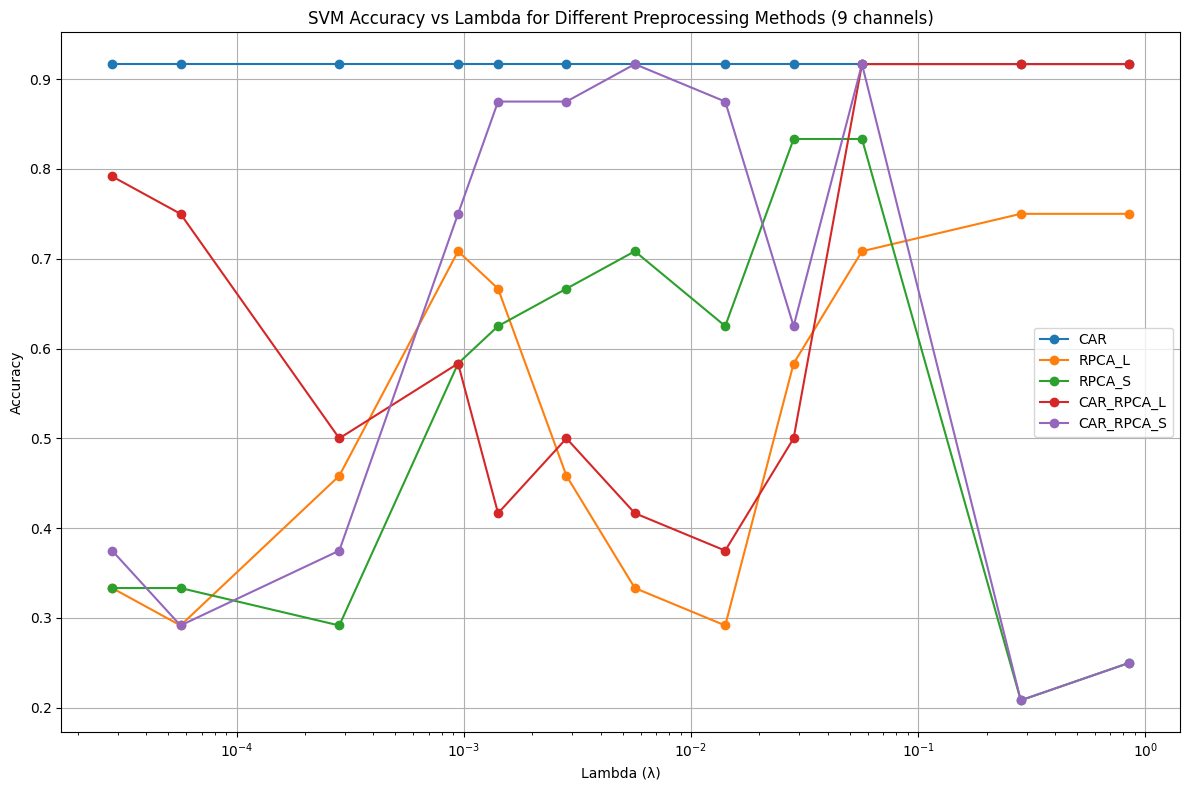

[np.float64(0.848528137423857), np.float64(0.282842712474619), np.float64(0.0565685424949238), np.float64(0.0282842712474619), np.float64(0.01414213562373095), np.float64(0.00565685424949238), np.float64(0.00282842712474619), np.float64(0.001414213562373095), np.float64(0.0009428090415820634), np.float64(0.000282842712474619), np.float64(5.6568542494923805e-05), np.float64(2.8284271247461902e-05)]


In [18]:
# Plot SVM accuracies for each preprocessing method
plt.figure(figsize=(12, 8))
for i, method in enumerate(preprocessing_methods):
    # Extract accuracies for this method across all lambda values
    method_accuracies = lambda_svm_accuracies[:, i]
    plt.plot(lambda_values, method_accuracies, marker='o', label=method)

plt.xscale('log')
plt.xlabel('Lambda (λ)')
plt.ylabel('Accuracy')
plt.title(f'SVM Accuracy vs Lambda for Different Preprocessing Methods ({len(selected_channels)} channels)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(lambda_values)

### Accuracy (SVM) X Channels Count (Each Method)

#### Code

In [19]:
# best lambda value found earlier
l = 0.06324555320336758
mu = 0.007905694150420948
# mu = 10 * l

# Initialize data structures to store results
channels_svm_accuracies = []
channels_counts = []

# Loop through different channel sets
for channels_count, selected_channels in channels_sets.items():
    # Store the channel count for plotting
    channels_counts.append(channels_count)
    
    # List to store accuracies for each preprocessing method at this lambda value
    method_accuracies = []

    ### FILTERING ###
    # Apply CAR filter
    CAR_pre_processed_eeg_data = apply_car_filter(eeg_data)

    # Apply RPCA
    RPCA_L_pre_processed_eeg_data, RPCA_S_pre_processed_eeg_data = apply_rpca_filter(eeg_data, l, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)

    # Apply CAR then RPCA
    CAR_RPCA_L_pre_processed_eeg_data, CAR_RPCA_S_pre_processed_eeg_data = apply_rpca_filter(apply_car_filter(eeg_data), l, mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)

    ### FEATURE EXTRACTION ###
    # Create label representations for classification
    # Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
    Y_vector = get_label_vector(evoked_frequencies)

    # Y_matrix: One-hot encoded matrix representation of labels
    # (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
    Y_matrix = get_label_matrix(evoked_frequencies)

    # Feature extraction from CAR filtered data
    X_CAR = get_feature_matrix_from_eeg_time_domain(CAR_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from RPCA low-rank component
    X_RPCA_L = get_feature_matrix_from_eeg_time_domain(RPCA_L_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from RPCA sparse component
    X_RPCA_S = get_feature_matrix_from_eeg_time_domain(RPCA_S_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from CAR+RPCA low-rank component
    X_CAR_RPCA_L = get_feature_matrix_from_eeg_time_domain(CAR_RPCA_L_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from CAR+RPCA low-rank component
    X_CAR_RPCA_S = get_feature_matrix_from_eeg_time_domain(CAR_RPCA_S_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Make feature matrix list for all preprocessing methods
    X_LIST = [X_CAR, X_RPCA_L, X_RPCA_S, X_CAR_RPCA_L, X_CAR_RPCA_S]
    
    ### MODEL FITTING AND PREDICTION ###
    X_training_list = []
    X_validation_list = []

    for i, X in enumerate(X_LIST):
        X_train, X_val, \
        Y_vector_train, Y_vector_val, \
        Y_matrix_train, Y_matrix_val = train_test_split(
            X,
            Y_vector,
            Y_matrix,
            test_size=0.2,
            stratify=Y_vector,
            random_state=42  # For reproducibility
        )
        
        X_training_list.append(X_train)
        X_validation_list.append(X_val)
        
        # Store Y values only once (they're the same for all preprocessing methods)
        if i == 0:
            Y_vector_training, Y_vector_validation = Y_vector_train, Y_vector_val
            Y_matrix_training, Y_matrix_validation = Y_matrix_train, Y_matrix_val

    # Train models for each preprocessing method
    for i, method in enumerate(preprocessing_methods):
        print(f"\nTraining models for {method} preprocessing with lambda={l:.6f}...")

        # Train SVM model
        svm_model = SVC(kernel='linear')
        svm_model.fit(X_training_list[i], Y_vector_training)
        y_svm_pred = svm_model.predict(X_validation_list[i])
        
        # Calculate accuracy for this method
        accuracy = accuracy_score(Y_vector_validation, y_svm_pred)
        method_accuracies.append(accuracy)
    
    # Store accuracies for all methods at this channel count
    channels_svm_accuracies.append(method_accuracies)

# Convert to numpy array for easier manipulation
channels_svm_accuracies = np.array(channels_svm_accuracies)

iter: 0, err: 1.013953680202654, rank L: 4, cardinality of S: 327
iter: 100, err: 0.005895550766347116, rank L: 4, cardinality of S: 994
iter: 200, err: 0.005676652282808628, rank L: 4, cardinality of S: 992
iter: 300, err: 0.008269818494245346, rank L: 4, cardinality of S: 986
iter: 400, err: 0.006757415011231031, rank L: 4, cardinality of S: 990
iter: 0, err: 0.9469113873256094, rank L: 4, cardinality of S: 343
iter: 100, err: 0.003752701316151974, rank L: 4, cardinality of S: 988
iter: 200, err: 0.005336530240081994, rank L: 4, cardinality of S: 995
iter: 300, err: 0.006328516145295078, rank L: 4, cardinality of S: 995
iter: 400, err: 0.0058502649019662786, rank L: 4, cardinality of S: 989
iter: 500, err: 0.015077262320794121, rank L: 4, cardinality of S: 988
iter: 0, err: 0.9590294815170415, rank L: 4, cardinality of S: 328
iter: 100, err: 0.007861540026999077, rank L: 4, cardinality of S: 995
iter: 200, err: 0.012874071191442849, rank L: 4, cardinality of S: 989
iter: 300, err: 0.

#### Plot

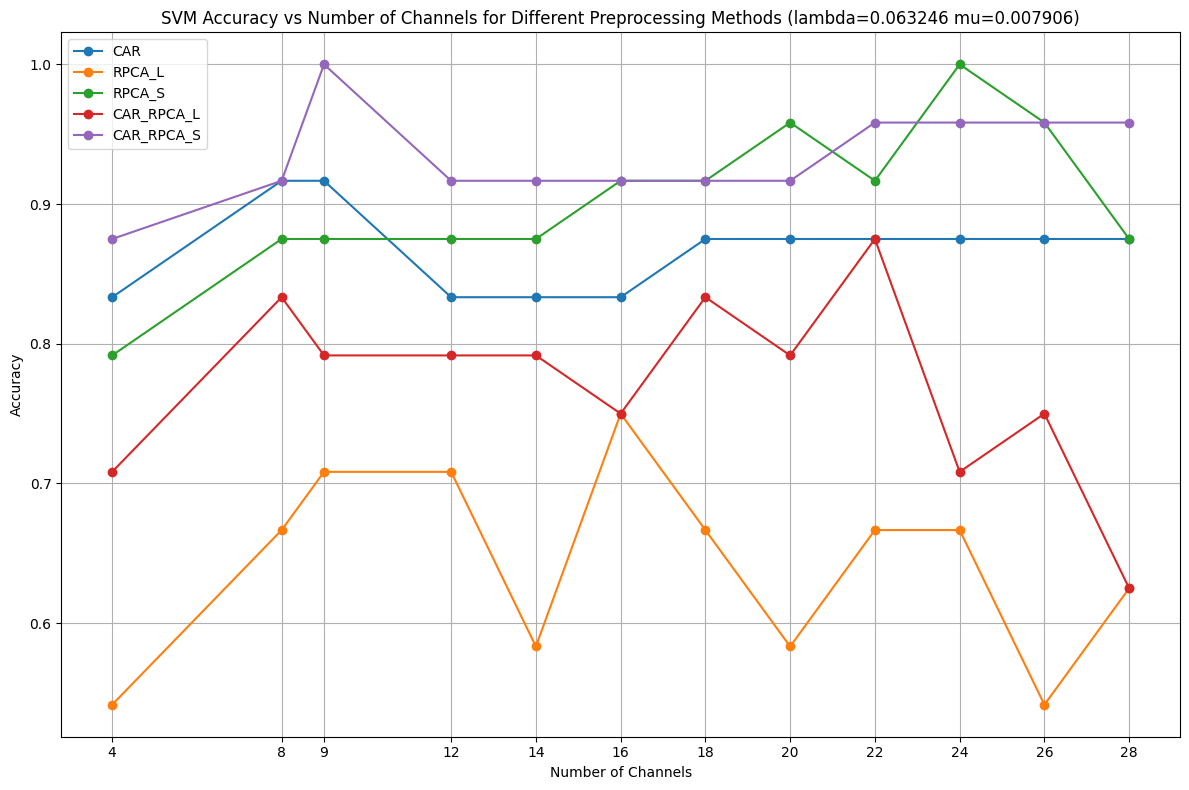

In [20]:
# Plot SVM accuracies for each preprocessing method across different channel counts
plt.figure(figsize=(12, 8))
for i, method in enumerate(preprocessing_methods):
    # Extract accuracies for this method across all channel counts
    method_accuracies = channels_svm_accuracies[:, i]
    plt.plot(channels_counts, method_accuracies, marker='o', label=method)

plt.xlabel('Number of Channels')
plt.ylabel('Accuracy')
plt.title(f'SVM Accuracy vs Number of Channels for Different Preprocessing Methods (lambda={l:.6f} mu={mu:.6f})')
plt.legend()
plt.grid(True)
plt.xticks(channels_counts)
plt.tight_layout()
plt.show()